# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.options.mode.chained_assignment = None

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject as dp


# Read and clean data

In [7]:
#loads data and sorts out non-prescription subjects
prices = pd.read_csv(r'Data.csv', sep=',')
ren = {0:'atc_code',1:'product_number',2:'pack_name',3:'marketing_owner',4:'form',5:'strength',6:'pack_size',7:'registration_status',8:'delivery_provision',9:'delivery_provision_change',10:'quantity_unit',11:'note',12:'subsidy_status',13:'substitution_group',14:'language'}
product_info = pd.read_table(r'product_name_text.txt', sep=';', encoding='latin',header=None).rename(columns=ren)
samlet_info=pd.merge(prices, product_info, on='product_number', how='left')
rcpt = samlet_info[samlet_info['delivery_provision'].str.contains('Receptpligtigt', na=False)]
rcpt = rcpt[rcpt['price_unit'].str.contains('ddd', na=False)]

Do not sort out prescription drugs as it is only interesting not to look at.It is only interesting to look at prescription as it can have cyclical patterns

In [8]:
#Price jump of +50% is found and inserted into new dataframe, "crit"  
priser=rcpt.groupby(['substitution_group', 'date'])['price']
pris = priser.min().unstack('substitution_group', fill_value=0)
prispct = pris.pct_change()
crit= pd.DataFrame([])
crit['jump up']=prispct[prispct>=0.5].replace([np.inf, -np.inf], np.nan).max().dropna()
pris=pris[crit.index] #frasortering af subgrupper uden hop
prispct = pris.pct_change().replace([np.inf, -np.inf], 0)

In [9]:
#Df which counts up the number of periods before jumping
dfboolrev = (prispct>=0.5).astype(int).replace(0,2).replace(1,0).replace(2,1) #bytte om på 1/0 til 0/1 som True/False
dataplus = dfboolrev.replace(1, np.nan, inplace=False)
a = dataplus.isnull()
b = a.cumsum()
c = dataplus.bfill()
d = c + (b-b.mask(a).bfill().fillna(0).astype(int)).sub(1)
dataplus=  dataplus.fillna(d)
dataplus = pd.DataFrame(data=dataplus, index=dfboolrev.index, columns=dfboolrev.columns)

In [10]:
#Df which counts up the number of periods after jumps
datamin = dfboolrev.replace(1, np.nan, inplace=False)
a = datamin.isnull()
b = a.cumsum()
c = datamin.ffill()
d = c + (b-b.mask(a).ffill().fillna(0).astype(int)).sub(0)
datamin =  datamin.fillna(d)
datamin = pd.DataFrame(data=datamin, index=dfboolrev.index, columns=dfboolrev.columns)

In [11]:

unsprismin2 = priser.nsmallest(2).groupby(['substitution_group', 'date']).last()
unsprismin2 = unsprismin2.unstack('substitution_group', fill_value=0)
unsprismin2 = unsprismin2[crit.index]

In [12]:
unsprismin3 = priser.nsmallest(3).groupby(['substitution_group', 'date']).last()
unsprismin3 = unsprismin3.unstack('substitution_group', fill_value=0)
unsprismin3 = unsprismin3[crit.index]

In [13]:
#The number of bidding companies for each period for each subgroup
antal = rcpt.groupby(['substitution_group', 'date','marketing_owner'])['price']
antal = antal.min().unstack('marketing_owner', fill_value=0)
antal = antal[antal.iloc[:]>0].count(axis='columns')
antal = antal.reset_index()
antal['Comp']=antal[0]
del antal[0]

unsantal = antal.set_index('substitution_group')
unsantal = unsantal.groupby(['substitution_group', 'date'])['Comp']
unsantal = unsantal.min().unstack('substitution_group', fill_value=0)
unsantal = unsantal[crit.index]


datatall = pd.melt(dataplus.reset_index(), id_vars='date', var_name='substitution_group', value_name='jumpplus')
datatall['jumpmin'] = pd.melt(datamin.reset_index(), id_vars='date', var_name='substitution_group', value_name='jumpmin')['jumpmin']
datatall['pris']  = pd.melt(pris.reset_index(), id_vars='date', var_name='substitution_group', value_name='pris')['pris']
#datatall['prispct']  = pd.melt(prispct.reset_index(), id_vars='date', var_name='substitution_group', value_name='pris')['prispct']
datatall['pris2'] = pd.melt(unsprismin2.reset_index(), id_vars='date', var_name='substitution_group', value_name='pris2')['pris2']
datatall['pris3'] = pd.melt(unsprismin3.reset_index(), id_vars='date', var_name='substitution_group', value_name='pris3')['pris3']
datatall['antal'] = pd.melt(unsantal.reset_index(), id_vars='date', var_name='substitution_group', value_name='antal')['antal']



datatall['tm'] = np.nan
datatall['tp'] = np.nan
I = datatall.jumpmin.notnull()
datatall.loc[I, 'tm'] = datatall.loc[I, 'jumpmin']
I = datatall.jumpplus.notnull()
datatall.loc[I, 'tp'] = datatall.loc[I, 'jumpplus']


delrange = datatall.loc[(datatall['jumpmin']<=20) | ((datatall['jumpplus']>=-20))].loc[datatall['antal']<2].groupby('substitution_group').mean()
dat = datatall[~datatall['substitution_group'].isin(delrange.index)]


mins=dat[dat['jumpplus']==-1].dropna()[dat[dat['jumpplus']==-1].dropna()['jumpmin']<20]['substitution_group']
mans=dat[dat['jumpmin']==1].dropna()[dat[dat['jumpmin']==1].dropna()['jumpplus']>-20]['substitution_group']


alt = np.unique(np.concatenate((mans.to_frame().drop_duplicates(), mins.to_frame().drop_duplicates())))
dat2 = dat[~dat['substitution_group'].isin(pd.DataFrame(data=alt, index=alt)[0])]
b=dat2['antal']>2
dat2['pris3'][~b]=np.nan

C:\Users\Bruger\AppData\Local\Temp\ipykernel_9744\54643120.py:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  delrange = datatall.loc[(datatall['jumpmin']<=20) | ((datatall['jumpplus']>=-20))].loc[datatall['antal']<2].groupby('substitution_group').mean()


In [14]:

#Insert ATC grupper
atcgrp = rcpt.groupby(['substitution_group', 'date', 'atc_code'])['price']
atcgrp = atcgrp.min().unstack('substitution_group', fill_value=0)

atc = atcgrp.columns.to_frame()
atc['koder'] = 0
del atc['substitution_group']

a = atcgrp.iloc[:,0][atcgrp.iloc[:,0]>0].index.get_level_values('atc_code').unique().to_frame()
for i in range(1, len(atcgrp.columns)):
    b =atcgrp.iloc[:,i][atcgrp.iloc[:,i]>0].index.get_level_values('atc_code').unique().to_frame()
    a = a.append(b)

atc['koder']= a.index
atc['sg']=atc.index

dat2=dat2.merge(atc, left_on=['substitution_group'], right_on=['sg'], how='left')
dat2.merge(atc, left_on=['substitution_group'], right_on=['sg'], how='left')
#del dat2['sg']


dat2.to_csv('dat2.csv', index=False)


data = pd.merge(dat2, rcpt,  how='left', left_on=['date','substitution_group'], right_on = ['date','substitution_group'])
pd.to_datetime(data['date'])
data = data[data['date']!=data['date'].shift(1)]
data['marketing_owner']
data.to_csv('Data50.csv', index=False)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_9744\3740790682.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  a = a.append(b)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_9744\3740790682.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  a = a.append(b)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_9744\3740790682.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  a = a.append(b)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_9744\3740790682.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  a = a.append(b)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_9744\3740790682.py:12: FutureWarning: The frame.append method is deprecated and

In [16]:
#explore dat2.
print (dat2)


                                date substitution_group  jumpplus  jumpmin  \
0      1970-01-01 00:00:00.020170102               31.0      -1.0      NaN   
1      1970-01-01 00:00:00.020170116               31.0       0.0      0.0   
2      1970-01-01 00:00:00.020170130               31.0       NaN      1.0   
3      1970-01-01 00:00:00.020170213               31.0       NaN      2.0   
4      1970-01-01 00:00:00.020170227               31.0       NaN      3.0   
...                              ...                ...       ...      ...   
23416  2022-08-22 00:00:00.000000000             3310.0       NaN    161.0   
23417                     2022-09-05             3310.0       NaN    162.0   
23418  2022-09-05 00:00:00.000000000             3310.0       NaN    163.0   
23419                     2022-09-19             3310.0       NaN    164.0   
23420  2022-09-19 00:00:00.000000000             3310.0       NaN    165.0   

           pris     pris2     pris3  antal     tm   tp    koder

Dat2 contains names of medcin on the Danish medicine market, names of companies, substitution group, price and ATC-code

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

In [8]:
#Overview of quantity, price
dat2 = pd.read_csv('dat2.csv', sep=',')
dat2[dat2['tp']==0].describe()[['pris','antal']]


,pris,antal
count,149.000000,149.000000
mean,6.724420,3.134228
std,7.926484,1.200550
min,0.210125,2.000000
25%,1.903889,2.000000
50%,5.118333,3.000000
75%,8.457500,4.000000
max,55.972789,7.000000


# Analysis and plots

C:\Users\Bruger\AppData\Local\Temp\ipykernel_9744\3147966100.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  antalgrouped = datat.append(datatm)


(-20.0, 20.0)

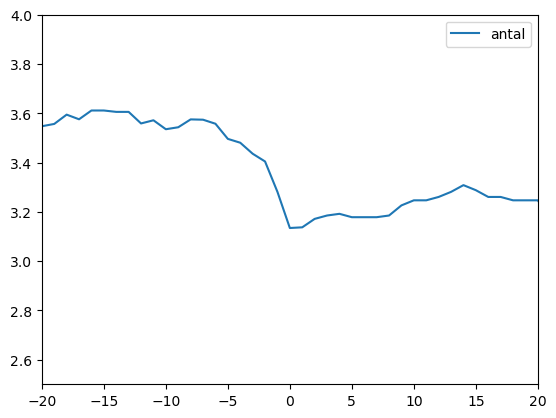

In [19]:
#loads dat2 to investigate how many companies participate in a bidding round that happens every 14 days
dat2 = pd.read_csv('dat2.csv', sep=',')

#find the average number of compaines in the bidding round
datat = dat2.groupby('tp').antal.mean().to_frame()
datatm =dat2.groupby('tm').antal.mean().to_frame()
antalgrouped = datat.append(datatm)
antalgrouped.plot()
plt.ylim(2.5,4)
plt.xlim(-20, 20)


Towards t=0, the number of companies in the bidding round will decrease to about 3.2

Text(0, 0.5, 'price')

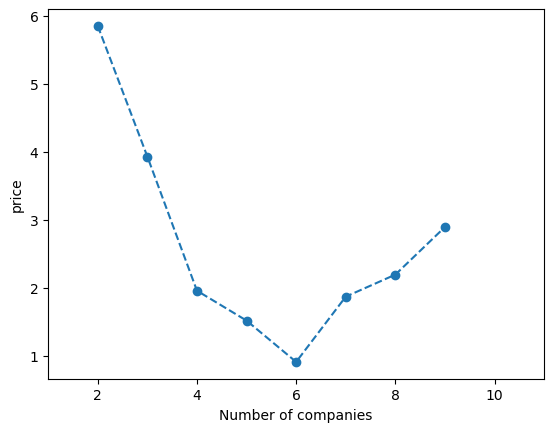

In [9]:
#Now we find the median of firms and plot them
median_pris=dat2.groupby('antal').pris.median().loc[2:10]
median_pris
plt.plot(median_pris,'--o')
plt.xlim(1,11)
plt.xlabel('Number of companies')
plt.ylabel('price')


Here you can see how the price develops in relation to the number of companies. the price will therefore fall towards 6 participating companies, after that the price rises again

C:\Users\Bruger\AppData\Local\Temp\ipykernel_9744\3770419253.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataforskel1 = datforskel1p.append(datforskel1m)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_9744\3770419253.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataforskel2 = datforskel2p.append(datforskel2m)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_9744\3770419253.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataforskel3 = datforskel3p.append(datforskel3m)


(0.0, 5.0)

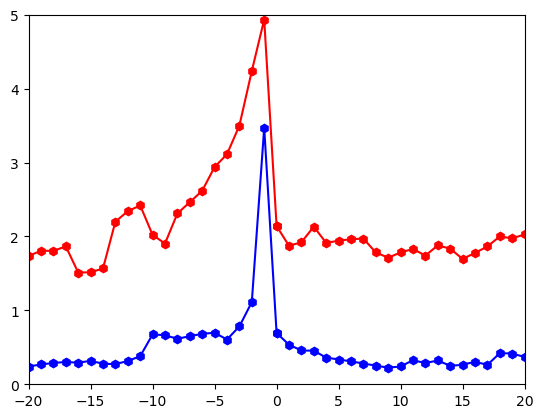

In [21]:
#In order to examine more closely how the prices develop in relation to each other, the relationship between the two lowest is looked at
#price difference between 1 and 2
prisforskel=dat2['pris2']-dat2['pris']
dat2['prisforskel']=prisforskel
datforskel1p = dat2.groupby('tp').prisforskel.mean().to_frame()
datforskel1m =dat2.groupby('tm').prisforskel.mean().to_frame()
dataforskel1 = datforskel1p.append(datforskel1m)

#price difference between 1 and 3
prisforskel2=dat2['pris3']-dat2['pris']
dat2['prisforskel2']=prisforskel2
datforskel2p = dat2.groupby('tp').prisforskel2.mean().to_frame()
datforskel2m =dat2.groupby('tm').prisforskel2.mean().to_frame()
dataforskel2 = datforskel2p.append(datforskel2m)

#price difference between 2 and 3
prisforskel3=dat2['pris3']-dat2['pris2']
dat2['prisforskel3']=prisforskel3
datforskel3p = dat2.groupby('tp').prisforskel3.mean().to_frame()
datforskel3m =dat2.groupby('tm').prisforskel3.mean().to_frame()
dataforskel3 = datforskel3p.append(datforskel3m)

plt.plot(dataforskel2,'r-h')
plt.plot(dataforskel1,'b-h')
plt.xlim(-20, 20)
plt.ylim(0,5)
plt.xlabel('T')
plt.ylabel('Price DKK')



Red line difference between winning price and third lowest and blue lowest and second lowest

C:\Users\Bruger\AppData\Local\Temp\ipykernel_12520\2852456823.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datatvar   = datat.append(datatm)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_12520\2852456823.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datatvart  = datatt.append(datatmm)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_12520\2852456823.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datatvar   = datat.append(datatm)


pris    1.810926
dtype: float64

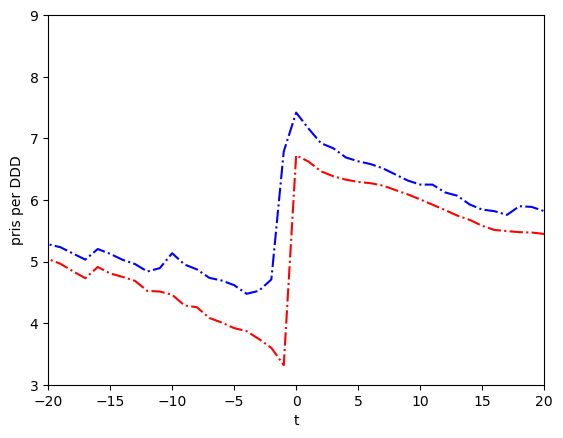

In [4]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
dat2 = pd.read_csv('dat2.csv', sep=',')
#the average price over all periods in the data set is looked at
datat      = dat2.groupby('tp').pris.mean().to_frame()
datatm     = dat2.groupby('tm').pris.mean().to_frame()
datatvar   = datat.append(datatm)
datatt     = dat2.groupby('tp').pris2.mean().to_frame()
datatmm    = dat2.groupby('tm').pris2.mean().to_frame()
datatvart  = datatt.append(datatmm)
datatvar   = datat.append(datatm)
# datattt    = dat2.groupby('tp').pris3.mean().to_frame()
# datatmmm   = dat2.groupby('tm').pris3.mean().to_frame()
# datatvartt = datattt.append(datatmmm)
plt.plot(datatvar,'r-.')
plt.plot(datatvart,'b-.')
# plt.plot(datatvartt,'g-h')
plt.xlim(-20,20)
plt.ylim(3,9)
plt.xlabel('T')
plt.ylabel('price per DDD')

## Average recovery after 10 periods
datatvar.loc[10]/datatvar.loc[-1]

Explain what you see when moving elements of the interactive plot around. 

C:\Users\Bruger\AppData\Local\Temp\ipykernel_12520\707717017.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datgnsan = d4.groupby('tp').pris.mean().to_frame().append(d4.groupby('tm').pris.mean().to_frame())
C:\Users\Bruger\AppData\Local\Temp\ipykernel_12520\707717017.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datgnsan2 = d5.groupby('tp').pris.mean().to_frame().append(d5.groupby('tm').pris.mean().to_frame())
C:\Users\Bruger\AppData\Local\Temp\ipykernel_12520\707717017.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datgnsan3 = d6.groupby('tp').pris.mean().to_frame().append(d6.groupby('tm').pris.mean().to_frame())
C:\Users\Bruger\AppData\Local\Temp\ipykernel_12520\707717017.py:23: FutureWarning: The frame

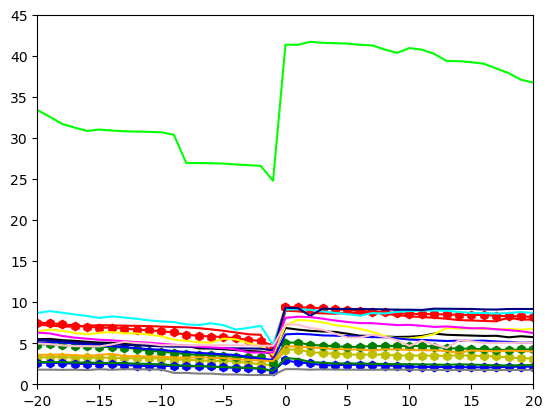

In [5]:
dat2 = pd.read_csv('dat2.csv', sep=',')

dat3=dat2.loc[(dat2['jumpmin']<=20) & (dat2['jumpplus']>=-20)]
dat3=dat3.groupby(['substitution_group']).antal.mean()
dat3 = dat3.to_frame()
dat3['sg'] = dat2['substitution_group'].unique()
dat3=dat2.merge(dat3, left_on=['substitution_group'], right_on=['sg'], how='left')


#del dat3['sg']
dat3 = dat3.rename(columns={"antal_x": "antal", "antal_y": "gnsantal"})

d4=dat3.loc[(dat3['gnsantal']>=2) & (dat3['gnsantal']<=3)]
datgnsan = d4.groupby('tp').pris.mean().to_frame().append(d4.groupby('tm').pris.mean().to_frame())

d5=dat3.loc[(dat3['gnsantal']>3) & (dat3['gnsantal']<=4)]
datgnsan2 = d5.groupby('tp').pris.mean().to_frame().append(d5.groupby('tm').pris.mean().to_frame())

d6=dat3.loc[(dat3['gnsantal']>4) & (dat3['gnsantal']<=5)]
datgnsan3 = d6.groupby('tp').pris.mean().to_frame().append(d6.groupby('tm').pris.mean().to_frame())

d7=dat3.loc[(dat3['gnsantal']>5)]
datgnsan4 = d7.groupby('tp').pris.mean().to_frame().append(d7.groupby('tm').pris.mean().to_frame())

plt.plot(datgnsan,'r-h')
plt.plot(datgnsan2,'y-h')
plt.plot(datgnsan3,'g-h')
plt.plot(datgnsan4,'b-h')

plt.ylim(0,12)
plt.xlim(-20,20)

Left = dat3['koder'].str[:1]
dat3['Left']=Left
colors=(['red', 'black', 'yellow', 'blue', 'green','grey', 'aqua', 'orange', 'navy', 'magenta', 'lime', 'pink'])
ncolor=0
for x in dat3['Left'].unique():
    x = dat3.loc[(dat3['Left']==x)]
    x = x.groupby('tp').pris.mean().to_frame().append(x.groupby('tm').pris.mean().to_frame())
    plt.plot(x, color=colors[ncolor])
    plt.ylim(0,45)
    plt.xlim(-20,20)
    ncolor+=1

# Conclusion

Based on the produced graph, it can be seen where the price of medicine on the Danish market develops in relation to the wood rounds that occur every 14 days.It can be seen that the prices will develop into something similar to cyclical prices. It can also be seen that the number of share companies on the market will influence the price and how the price recovers after a price jump.